# Streetscapes workspaces

This notebook illustrates how to use project workspaces in Streetscapes. You can load different data sources and ML models, process streetview images and save generated data to your workspace.

This notebook includes the following steps:

- [Define a workspace](#1---define-a-workspace)
- [Subset data](#2---subset-data)
- [Visualise data](#3---visualise-data)
- [Download images](#4---download-images)
- [Segment images](#5---segment-images)
- [Calculate statistics](#6---calculate-statistics)
- [Rasterise data](#7---rasterise-data)

### 0 - Libraries

In [10]:
# --------------------------------------
import warnings

warnings.filterwarnings("ignore")

# --------------------------------------
import ibis

ibis.options.interactive = True

# --------------------------------------
from streetscapes.models import ModelType
from streetscapes.sources import SourceType
from streetscapes.streetview import SVWorkspace

### 1 - Define a workspace

Streetscapes has a workspace functionality to facilitate data analysis. Within this workspace, downloaded data, images, segmented masks and analysis for a certain project are self contained and reproducible. 

<span style="color:grey;"><i> Note: You can also pass the path to an `.env` file containing configuration options for the workspace. By default, the workspace looks for an `.env` file inside the workspace directory, and if it doesn't exist, it walks the parent tree until it finds one or it reaches the root of the file system. Environment variables are also recognised automatically.</i></span>

First, create a workspace or load an existing one. In this tutorial, we will be doing an analysis of Amsterdam, so we are naming our workspace "Amsterdam":

In [11]:
ws = SVWorkspace("./Amsterdam", create=True)

Let's now look at where this new workspace is located:

In [12]:
workspace_path = ws.get_workspace_path("")
workspace_path

PosixPath('/Users/clairedonnelly/Documents/Urban-M4/test/streetscapes/docs/tutorial/Amsterdam')

Now let's add which source of images we would like to use. Possible are sources are: [Mapillary](https://www.mapillary.com/), [Kartaview](https://kartaview.org/), [Google Streetview](https://developers.google.com/maps/documentation/streetview) and [Amsterdam Open Panorama](https://amsterdam.github.io/projects/open-panorama/). It is also possible to use [Global Streetscapes](https://ual.sg/project/global-streetscapes/) as a data source. 

In this example, we will use Global Streetscapes, Kartaview and Mapillary. 

<span style="color:red;">NOTE</span>: Make sure you have the appropriate API keys stored in your `.env` file. 

In [13]:
gss = ws.add_source(SourceType.GlobalStreetscapes)
kv = ws.add_source(SourceType.KartaView)
mp = ws.add_source(SourceType.Mapillary)

We can then view where these data sources are located. This will be where all images, instances and masks will be stored. 

In [14]:
gss, kv, mp

(GlobalStreetscapesSource(root_dir='~/.cache/huggingface/hub/datasets--NUS-UAL--global-streetscapes'),
 KartaViewSource(root_dir='~/.cache/huggingface/assets/streetscapes/images/karta_view'),
 MapillarySource(root_dir='~/.cache/huggingface/assets/streetscapes/images/mapillary'))

If we show the contents of the workspace directory, we can see that a subdirectory for Amsterdam was created as well as a [duckdb](https://duckdb.org/) metadata file.

In [15]:
ws.show_contents()

Amsterdam/
├─metadata.db
└─subsets/
  └─amsterdam.parquet


To test that the connection to our data sources work, we can get the image URLs for a KartaView and a Mapillary image:

In [16]:
kv_img_url = kv.get_image_url(1208524)
kv_img_url

'https://storage2.openstreetcam.org/files/photo/2016/5/5/proc/3823_3446d_572b6b13bdfca.jpg'

In [17]:
mp_img_url = mp.get_image_url("4911230068985425")
mp_img_url

'https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/An--rrF4WlM05JH5SMiWxbdSXVWL0mFEymquJWW0EmSjaBemmKBcF8DRGqIe8akNayRiH0VTYunIfeHZlt2zAGA0sYkEkeWIUtnfp27cgiCen37fra1_v0gwTJFgNL5wTiUGkS7F56f_yLBZF1HqZg?edm=ALXxkZ8EAAAA&_nc_gid=s0SBRedx_raOcgMA1GS5dA&_nc_oc=AdlLWq6SzSf1M-jZKBxoOoVEyU3X9YwZhLlEnbppO3A3w6rIbFdRkCcuM0bXDaiL9-o&ccb=10-5&oh=00_AfHmLS-HVnULfpxXq0uciF0jLqGqLoyk65ixAMNNKEv5kg&oe=68382FBC&_nc_sid=201bca'

### 2 - Subset data

Let's have a more detailed look into the data sources that we have loaded. Choose a bounding box for the area you would like to download images for and fetch the image ids from Mapillary.

In [18]:
bbox = [4.883466,52.361790,4.916210,52.381494]
df = mp.fetch_image_ids(bbox=bbox)
df

id   altitude  atomic_scale      camera_type  \
0    1728619477874440   1.694540      0.989727      perspective   
1    3127546224207918  50.684000      1.004457          fisheye   
2    3151368791834527  54.820000      0.982875          fisheye   
3    1629017677881556  55.898000      1.000000          fisheye   
4    3027256710879992  45.063716      0.999298  equirectangular   
..                ...        ...           ...              ...   
482  1732747930500064  47.525000      0.916550          fisheye   
483  6036304206479414   1.847000      1.638512          fisheye   
484  1439070203297534  53.706000      0.984427          fisheye   
485  1697488181062416  53.015000      1.062796      perspective   
486  5376168772432445  29.444000      0.969788      perspective   

       captured_at  compass_angle  computed_altitude  computed_compass_angle  \
0    1725956589515     101.730172           1.159581              109.268159   
1    1683207685000     131.756581           5.731942              121.042762   
2    1687891075000     311.691000           2.407281              298.028215   
3    1717398721000      96.437000           0.420238              100.721411   
4    1489398125712       0.000000           1.983869                0.045323   
..             ...            ...                ...                     ...   
482  1687352523000      16.545000           2.141512               50.017489   
483  1687534698000     206.473000           4.256935              176.722969   
484  1683209182000      77.067298           2.304483               35.212048   
485  1723702651000     114.000000           3.248722              128.747921   
486  1660995855000       0.000000           4.299081              296.184683   

                                     computed_geometry  \
0    {'type': 'Point', 'coordinates': [4.8941148024...   
1    {'type': 'Point', 'coordinates': [4.8864114092...   
2    {'type': 'Point', 'coordinates': [4.8866493118...   
3    {'type': 'Point', 'coordinates': [4.8850413056...   
4    {'type': 'Point', 'coordinates': [4.8866440132...   
..                                                 ...   
482  {'type': 'Point', 'coordinates': [4.8845186317...   
483  {'type': 'Point', 'coordinates': [4.8931196193...   
484  {'type': 'Point', 'coordinates': [4.8972348186...   
485  {'type': 'Point', 'coordinates': [4.8940200377...   
486  {'type': 'Point', 'coordinates': [4.8920731143...   

                                     computed_rotation  ...     make  \
0    [0.94069597971288, -1.260936640236, 1.60094801...  ...    Apple   
1    [0.71298867277655, -1.4793233907462, 1.5908211...  ...    GoPro   
2    [1.3427578920446, 0.83444329038152, -0.8334462...  ...    GoPro   
3    [1.2006256492038, -1.3400907520982, 1.38258193...  ...    GoPro   
4    [1.570273825793, 0.00086313241438706, 0.002106...  ...  Trimble   
..                                                 ...  ...      ...   
482  [1.4046625625089, -0.54702064233501, 0.8143646...  ...    GoPro   
483  [0.038301840761932, -2.1533243485955, 2.209033...  ...    GoPro   
484  [1.437386732418, -0.44234329213943, 0.51036052...  ...    GoPro   
485  [0.83584881650292, -1.7189209270313, 1.6698337...  ...  samsung   
486  [1.6789566750888, 0.85860065559891, -0.9041878...  ...    GoPro   

             model                                      thumb_256_url  \
0    iPhone 13 Pro  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
1      HERO7 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
2      HERO7 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
3      HERO7 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
4      Trimble TMX  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
..             ...                                                ...   
482    HERO7 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
483    HERO7 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
484    HERO7 Black  https://sconte

### 3 - Visualise Data

Now that we have subsetted the data, we might want to see where the images we want to download are located and if we have good coverage of the city. 

First, the table needs to be converted to a geopandas dataframe and given an appropriate CRS. 

In [19]:
import geopandas as gpd
import contextily

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)

id   altitude  atomic_scale      camera_type  \
0    1728619477874440   1.694540      0.989727      perspective   
1    3127546224207918  50.684000      1.004457          fisheye   
2    3151368791834527  54.820000      0.982875          fisheye   
3    1629017677881556  55.898000      1.000000          fisheye   
4    3027256710879992  45.063716      0.999298  equirectangular   
..                ...        ...           ...              ...   
482  1732747930500064  47.525000      0.916550          fisheye   
483  6036304206479414   1.847000      1.638512          fisheye   
484  1439070203297534  53.706000      0.984427          fisheye   
485  1697488181062416  53.015000      1.062796      perspective   
486  5376168772432445  29.444000      0.969788      perspective   

       captured_at  compass_angle  computed_altitude  computed_compass_angle  \
0    1725956589515     101.730172           1.159581              109.268159   
1    1683207685000     131.756581           5.731942              121.042762   
2    1687891075000     311.691000           2.407281              298.028215   
3    1717398721000      96.437000           0.420238              100.721411   
4    1489398125712       0.000000           1.983869                0.045323   
..             ...            ...                ...                     ...   
482  1687352523000      16.545000           2.141512               50.017489   
483  1687534698000     206.473000           4.256935              176.722969   
484  1683209182000      77.067298           2.304483               35.212048   
485  1723702651000     114.000000           3.248722              128.747921   
486  1660995855000       0.000000           4.299081              296.184683   

                                     computed_geometry  \
0    {'type': 'Point', 'coordinates': [4.8941148024...   
1    {'type': 'Point', 'coordinates': [4.8864114092...   
2    {'type': 'Point', 'coordinates': [4.8866493118...   
3    {'type': 'Point', 'coordinates': [4.8850413056...   
4    {'type': 'Point', 'coordinates': [4.8866440132...   
..                                                 ...   
482  {'type': 'Point', 'coordinates': [4.8845186317...   
483  {'type': 'Point', 'coordinates': [4.8931196193...   
484  {'type': 'Point', 'coordinates': [4.8972348186...   
485  {'type': 'Point', 'coordinates': [4.8940200377...   
486  {'type': 'Point', 'coordinates': [4.8920731143...   

                                     computed_rotation  ...     make  \
0    [0.94069597971288, -1.260936640236, 1.60094801...  ...    Apple   
1    [0.71298867277655, -1.4793233907462, 1.5908211...  ...    GoPro   
2    [1.3427578920446, 0.83444329038152, -0.8334462...  ...    GoPro   
3    [1.2006256492038, -1.3400907520982, 1.38258193...  ...    GoPro   
4    [1.570273825793, 0.00086313241438706, 0.002106...  ...  Trimble   
..                                                 ...  ...      ...   
482  [1.4046625625089, -0.54702064233501, 0.8143646...  ...    GoPro   
483  [0.038301840761932, -2.1533243485955, 2.209033...  ...    GoPro   
484  [1.437386732418, -0.44234329213943, 0.51036052...  ...    GoPro   
485  [0.83584881650292, -1.7189209270313, 1.6698337...  ...  samsung   
486  [1.6789566750888, 0.85860065559891, -0.9041878...  ...    GoPro   

             model                                      thumb_256_url  \
0    iPhone 13 Pro  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
1      HERO7 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
2      HERO7 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
3      HERO7 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
4      Trimble TMX  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
..             ...                                                ...   
482    HERO7 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
483    HERO7 Black  https://scontent-ams4-1.xx.fbcdn.net/m1/v/t6/A...   
484    HERO7 Black  https://sconte

Then we can plot the image locations:

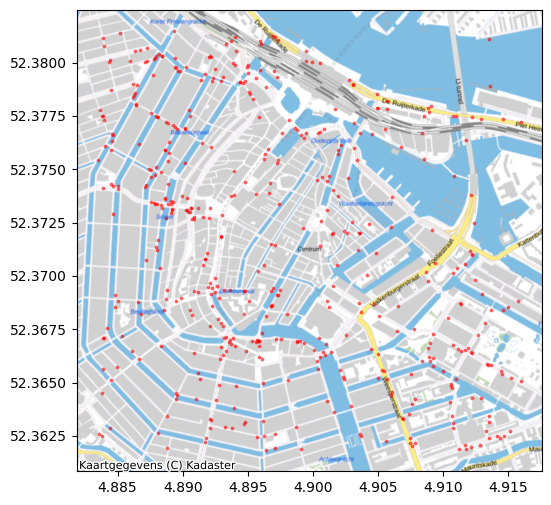

In [20]:
ax = gdf.plot(column='uuid', color='red', markersize=3, figsize=(6, 6), alpha=0.5)
contextily.add_basemap(ax, crs=gdf.crs, source=contextily.providers.nlmaps.standaard)

### 4 - Download images

Let's first download a single image: 

In [21]:
import requests

def download_image(url, filename):
    response = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(response.content)

image = gdf.iloc[0]
filename = mp.root_dir / (image.id + '.png')
url = image.thumb_2048_url
download_image(url, filename)

Now let's do this for the first 10 images of our dataset: 

In [22]:
df_sample = df.iloc[:10]
for i, image in df_sample.iterrows():
    filename = mp.root_dir / (image["id"] + '.jpeg')
    url = image.thumb_2048_url
    download_image(url, filename)

# Getting around the segmentation function requirements
# TODO: Fix needing to do this
df_sample["source"] = 'mapillary'
df_sample["image_id"] = df_sample["id"]

In [23]:
# TODO: Accept something other than an ibis table
sample = ibis.memtable(df_sample)
sample

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ id               ┃ altitude  ┃ atomic_scale ┃ camera_type     ┃ captured_at   ┃ compass_angle ┃ computed_altitude ┃ computed_compass_angle ┃ computed_geometry                                 ┃ computed_rotation                              ┃ exif_orientation ┃ geometry                                          ┃ height ┃ is_pano ┃ make    ┃ model         ┃ thumb_256_url                                                                    ┃ thumb_1024_url                                                                   ┃ thumb_2048_url                                                                   ┃ thumb_original_url                                                               ┃ sequence               ┃ width ┃ latitude  ┃ longitude ┃ source    ┃ image_id         ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ string           │ float64   │ float64      │ string          │ int64         │ float64       │ float64           │ float64                │ struct<coordinates: array<float64>, type: string> │ array<float64>                                 │ int64            │ struct<coordinates: array<float64>, type: string> │ int64  │ boolean │ string  │ string        │ string                                                                           │ string                                                                           │ string                                                                           │ string                                                                           │ string                 │ int64 │ float64   │ float64   │ string    │ string           │
├──────────────────┼───────────┼──────────────┼─────────────────┼───────────────┼───────────────┼───────────────────┼────────────────────────┼───────────────────────────────────────────────────┼────────────────────────────────────────────────┼──────────────────┼───────────────────────────────────────────────────┼────────┼─────────┼─────────┼───────────────┼──────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┼────────────────────────┼───────┼───────────┼───────────┼───────────┼──────────────────┤
│ 1728619477874440 │  1.694540 │     0.989727 │ perspective     │ 1725956589515 │    101.730172 │   

In [24]:
ws.get_workspace_path("")

PosixPath('/Users/clairedonnelly/Documents/Urban-M4/test/streetscapes/docs/tutorial/Amsterdam')

### 5 - Segment images

We can load various models and apply them to the image data that we have loaded or generated so far. Currently, Streetscapes supports two segmentation models:

- `MaskFormer`: A relatively small and nimble model that recognises objects from a fixed number of categories.
- `DinoSAM`: A combination of two independent models that work together to perform instance segmentation simply by providing a prompt. It is much more flexible than `MaskFormer` in that it recognises *arbitrary categories*; however, it is much slower.

We will segment the images with both models to illustrate their differences. First, we load the models using an API analogous to that for data sources, with the exception that models are spawned globally and can be reused across multiple workspaces since they are workspace-agnostic. This is another design choice to minimise memory consumption for potentially large models.

In [25]:
mf = ws.spawn_model(ModelType.MaskFormer)
ds = ws.spawn_model(ModelType.DinoSAM)

We define the categories of objects that we would like to look for in the images that we are segmenting. Categories are defined hierarchically as a nested dictionary. Subcategories (such as `window` and `door` below) will be identified as separate categories, but the pixels that they occupy will be subtracted from ones attributed to their parent (here, `building`). In this way, it is possible to extract building façades excluding windows and doors. Internally, this nested dictionary is flattened, and any overlaps are handled after instances of the corresponding categories have been identified.

In [26]:
labels = {
    "building": {
        "window": None,
        "door": None,
    },
    "vegetation": None,
    "car": None,
    "truck": None,
    "road": None,
}

Segment all images contained in a dataset. Here, we use our`sample` dataset that we created above. A batch size (defaulting to `10`) can be specified to speed up the segmentation, but here we use a batch size of 1 to show the progress more clearly.

In [27]:
#TODO: Make this function more flexible so columns names can be set
#TODO: Don't require a source and don't assume path to images? 
mf_segmentations = ws.segment_from_dataset(sample, mf, labels)

Streetscapes | 2025-04-29@15:33:34 | Reusing an existing Mapillary source, use the replace argument to override.
Done: 100%|██████████| 2/2 [00:19<00:00,  9.53s/it]                          


The masks and the instances are saved as separate files with the same name as the input image but in different formats (NumPy archived arrays and Parquet files, respectively) so that they can be loaded later together. Here, we print the name of the file containing the mask for the first segmented image.

In [28]:
mf_segmentations[0].mask_path.name

'1728619477874440.npz'

Show the categories (out of the ones that we requested) identified by this model.

In [29]:
mf_segmentations[0].get_instance_table().select('label').distinct()

┏━━━━━━━━━━━━━━┓
┃ label        ┃
┡━━━━━━━━━━━━━━┩
│ string       │
├──────────────┤
│ street-light │
│ bicycle      │
│ car          │
│ curb         │
│ sky          │
│ vegetation   │
│ road         │
│ building     │
│ sidewalk     │
│ pole         │
│ …            │
└──────────────┘

Visualise the parts of the image corresponding to some object categories of interest (here, we ask for everything that is labelled as a `building`).

(<Figure size 1600x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

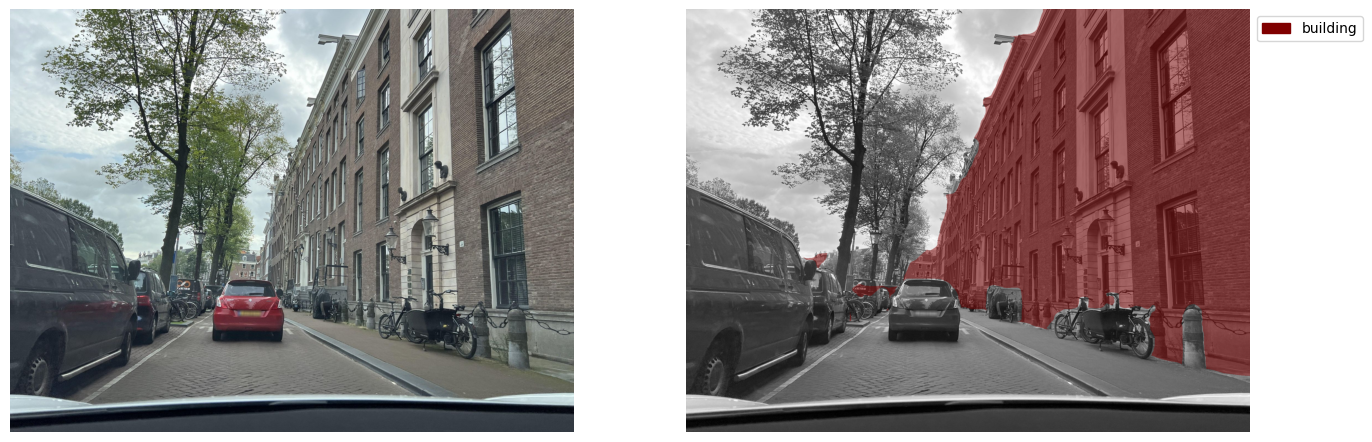

In [30]:
mf_segmentations[0].visualise('building')

If the `visualise()` method is called without an argument, all the identified categories are visualised.

(<Figure size 1600x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

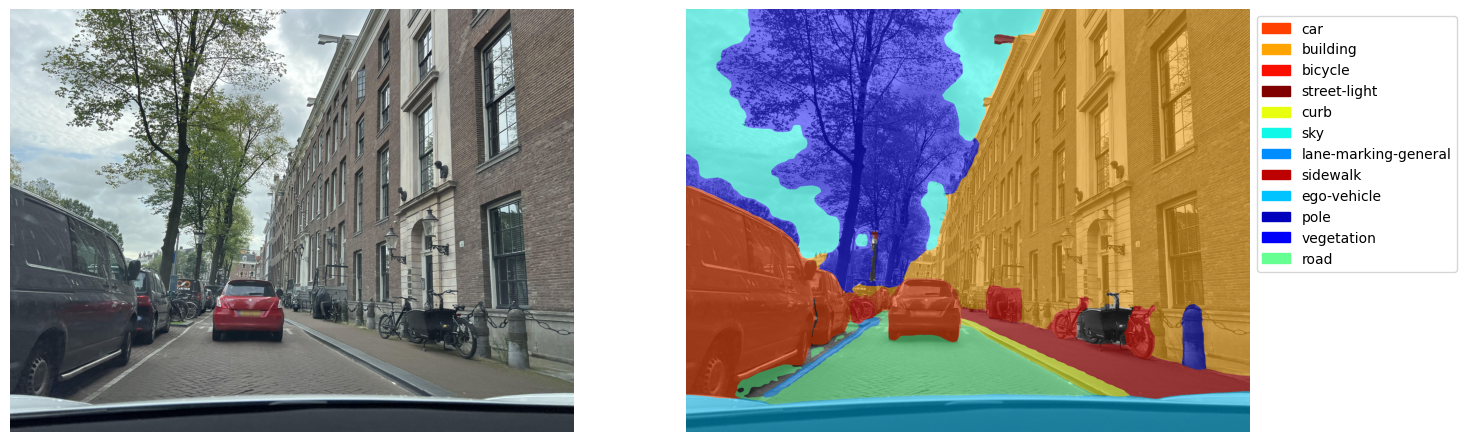

In [31]:
mf_segmentations[0].visualise()

We can also extract instances for individual categories and and visualise them in isolation.

(<Figure size 1600x600 with 1 Axes>, <Axes: >)

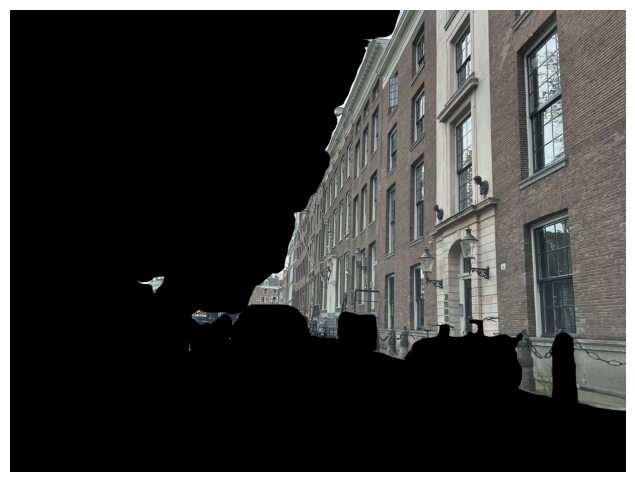

In [32]:
buildings = mf_segmentations[0].get_instances("building")
buildings[0].visualise(mf_segmentations[0].get_image())

We will now execute the same pipeline with the `DinoSAM` model.

In [33]:
ds_segmentations = ws.segment_from_dataset(sample, ds, labels, batch_size=1)

Streetscapes | 2025-04-29@15:33:54 | Reusing an existing Mapillary source, use the replace argument to override.
Done: 100%|██████████| 11/11 [01:10<00:00,  6.38s/it]                          


In [34]:
ds_segmentations[0].get_instance_table().select('label').distinct()

┏━━━━━━━━━━━━┓
┃ label      ┃
┡━━━━━━━━━━━━┩
│ string     │
├────────────┤
│ car        │
│ vegetation │
│ window     │
│ building   │
│ road       │
│ door       │
└────────────┘

(<Figure size 1600x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

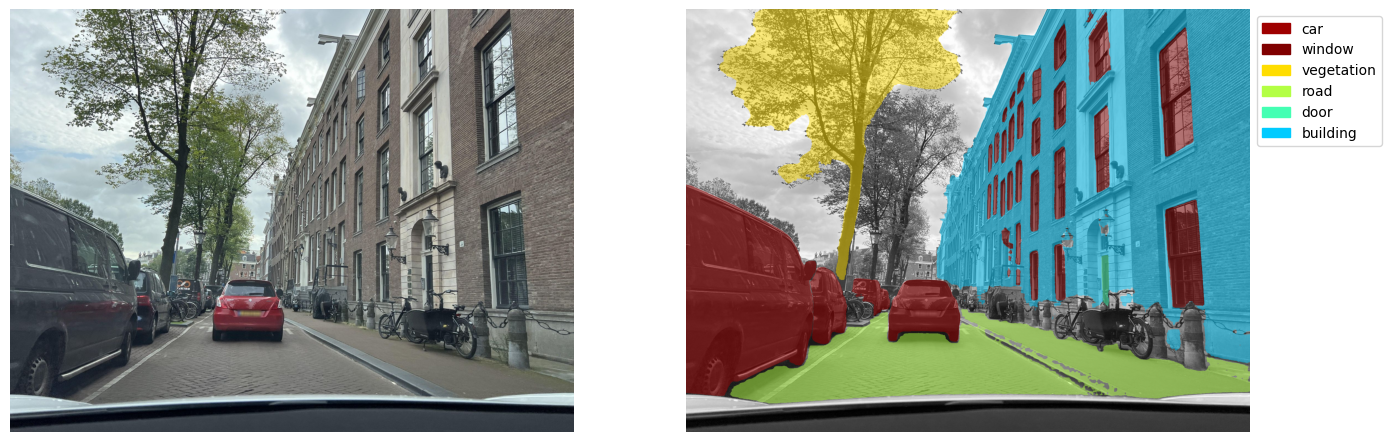

In [35]:
ds_segmentations[0].visualise()

In [36]:
ds_segmentations[0]

Segmentation(mask=/Users/clairedonnelly/.cache/huggingface/assets/streetscapes/images/mapillary/masks/dinosam/1728619477874440.npz

### 6 - Calculate statistics

In [37]:
import numpy as np

image_means = []
for seg in ds_segmentations:
    image = seg.get_image()
    buildings = seg.get_instances("building")
    building_means = []
    for building in buildings:
        # TODO: would be nice to have building.get_mask_3d or something like that
        mask_3d = np.repeat(building.mask[:, :, None], 3, axis=2)
        masked_img = np.ma.masked_array(image, mask=mask_3d)
        building_mean = masked_img.mean()
        building_means.append(building_mean)
    image_mean = np.mean(building_means)
    image_means.append(image_mean)

np.array(image_means)


array([118.49299597, 102.44524242, 116.11384527,  99.12581442,
        86.55498628,  92.47501995, 121.742283  , 119.15378044,
       100.2904993 ,  96.86735578, 118.49299597])

In [38]:
# # Wishful code for calculation means

# image_means = []
# for seg in ds_segmentations:
#     image = seg.get_image()
#     buildings = seg.get_instances("building")
#     # TODO: would be nice if we had a utility to directly calculate something on all instances at once
#     building_means = [building.mask_3d.mean() for building in buildings]
#     image_mean = np.mean(building_means)
#     image_means.append(image_mean)

# # Even more streamlined version
# pixel_mean = lambda pixels: pixels.mean
# image_means = [seg.get_all_instances("building").apply(pixel_mean) for seg in ds_segmentations]

(<Figure size 1600x600 with 1 Axes>, <Axes: >)

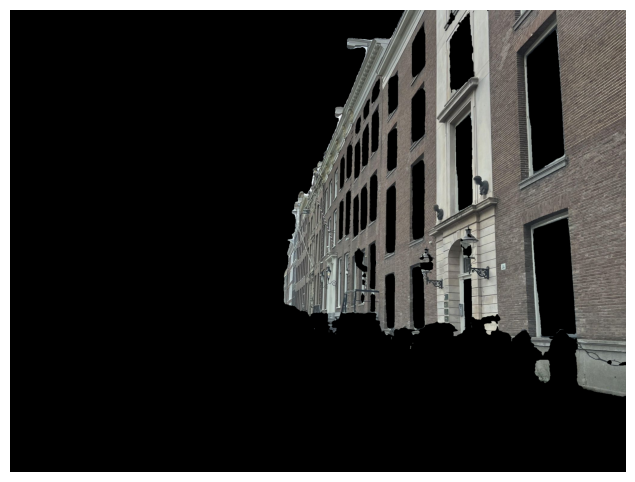

In [39]:
buildings[0].visualise(image)

### 7 - Rasterise data

Here we will use the geopandas dataframe we created early to create a raster. 

To rasterise points, you first need to create a template raster with the same extents and CRS as your input point data. 

In [40]:
import rasterio
import rasterio.features as rfeatures
import rasterio.plot as rplot
import math

gdf_proj = gdf.to_crs(28992)

bounds = gdf_proj.total_bounds
horizontal_resolution = 100
transform = rasterio.transform.from_origin(
    west=bounds[0], 
    north=bounds[3], 
    xsize=horizontal_resolution, 
    ysize=horizontal_resolution
)
transform

Affine(100.0, 0.0, np.float64(120696.89878669874),
       0.0, -100.0, np.float64(488296.2563685635))

Calculate output shape and create pairs of coordinates to values

In [41]:
rows = math.ceil((bounds[3] - bounds[1]) / horizontal_resolution)
cols = math.ceil((bounds[2] - bounds[0]) / horizontal_resolution)
shape = (rows, cols)

g = [(g, v) for g, v in gdf_proj[['geometry', 'Beautiful']] \
        .dropna(subset='Beautiful')
        .to_numpy() \
        .tolist()]

KeyError: "['Beautiful'] not in index"

Then, map these pairs to the template raster, which creates a rasterised dataset

In [ ]:
raster = rfeatures.rasterize(
    shapes=g,
    out_shape=shape,
    transform=transform,
    fill=np.nan
)
raster[:1]

Finally, plot the point data and the rasterised data to compare

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Plot the GeoDataFrame on the first subplot
ax = gdf_proj.plot(column='Beautiful', ax=ax1, cmap='RdYlGn', markersize=3, alpha=0.5)
contextily.add_basemap(ax, crs=gdf_proj.crs, source=contextily.providers.nlmaps.pastel)
ax1.set_title('Points')

# Plot the raster on the second subplot
rplot.show(raster, transform=transform, ax=ax2, cmap='RdYlGn')
ax2.set_title('Raster')

# Show the plot
plt.show()

We can also overlay the plots for easier comparison

In [ ]:
# Combined plot
fig, ax = plt.subplots(figsize=(5, 5))

# Plot points
gdf_proj.plot(column='Beautiful', ax=ax, cmap='RdYlGn', legend=True, markersize=3)

# Plot raster
rasterio.plot.show(raster, transform=transform, ax=ax, cmap='RdYlGn')

# Show the plot
plt.show()